<a href="https://colab.research.google.com/github/maverick98/CDS/blob/main/Mano_M5_Pyspark_ML_Additional_Notebook_(ungraded).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A Program by IISc and TalentSprint
### Additional Notebook (ungraded) on PySpark ML


## Learning Objectives

At the end of the experiment, you will be able to

* understand the concept of machine learning using PySpark
* Explore and visualize California housing dataset
* understand code implementation for performing machine learning using PySpark

### Introduction

### Machine Learning using PySpark

PySpark MLlib is a machine-learning library. It is like a wrapper over PySpark Core to do data analysis using machine-learning algorithms. It works on distributed systems and is scalable. It can be used for classification, clustering, linear regression, and other machine-learning algorithms in PySpark MLlib.

* It has a number advantages such as it is faster than previous approaches like MapReduce.
* It has multiple functions that it offers such as running distributed SQL.

To know more about a pyspark's ML pipeline click [here](https://spark.apache.org/docs/2.3.1/api/python/pyspark.ml.html#module-pyspark.ml.classification)


**Problem Statement:** Predicting House Prices using California Housing Dataset

In this section, we'll make use of the California Housing data set. Note, of course, that this is actually 'small', but, the purpose of this notebook is meant to give you an idea of how we can use PySpark to build a machine learning model.

**Dataset Description** : The California Housing data set appeared in a 1997 paper titled Sparse Spatial Autoregressions, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. The researchers built this data set by using the 1990 California census data.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

`Longitude`:refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

`Latitude` :refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

`Housing Median Age`:is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values

`Total Rooms`:is the total number of rooms in the houses per block group

`Total Bedrooms`:is the total number of bedrooms in the houses per block group

`Population`:is the number of inhabitants of a block group

`Households`:refers to units of houses and their occupants per block group

`Median Income`:is used to register the median income of people that belong to a block group

`Median House Value`:is the dependent variable and refers to the median house value per block group


The Median house value is the dependent variable and will be assigned the role of the target variable in our ML model.

In [1]:
#@title Run this cell to download the dataset
from IPython import get_ipython
ipython = get_ipython()
ipython.magic("sx wget https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/cal_housing.data")

['--2023-02-11 08:22:24--  https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/cal_housing.data',
 'Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210',
 'Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 2071484 (2.0M) [application/octet-stream]',
 'Saving to: ‘cal_housing.data’',
 '',
 '',
 'cal_housing.data      0%[                    ]       0  --.-KB/s               ',
 'cal_housing.data      1%[                    ]  39.75K   125KB/s               ',
 'cal_housing.data      4%[                    ]  87.75K   138KB/s               ',
 'cal_housing.data      7%[>                   ] 151.75K   159KB/s               ',
 'cal_housing.data     15%[==>                 ] 311.75K   245KB/s               ',
 'cal_housing.data     32%[=====>              ] 647.75K   408KB/s               ',
 'cal_housing.data     63%[===========>       

### Importing the required libraries and packages

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 19.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=b29faa813e8305b87c54d377135861cbb8c7cc50fcaee046e1f2b4c3e195e4e2
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [3]:
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import FloatType

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Setting random seed
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

#### Creating the Spark Session

In [6]:
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()

In [7]:
spark

Creating Spark Context

In [8]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

Creating SQL Context

In [9]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#### Load The Data From the File

In [10]:
HOUSING_DATA = '/content/cal_housing.data'

Specifying the schema when loading data into a DataFrame will give better performance than schema inference.

In [11]:
# Define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [12]:
# Load housing data
housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()

In [13]:
# Inspect first five rows
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [14]:
# Display first five rows
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [15]:
# Show the dataframe columns
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [16]:
# Show the schema of the dataframe
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



### Data Exploration

In [17]:
# Run a sample selection
housing_df.select('pop','totbdrms').show(10)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows



### Distribution of the median age of the people living in the area

In [18]:
# Group by housing median age and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)

In [19]:
result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



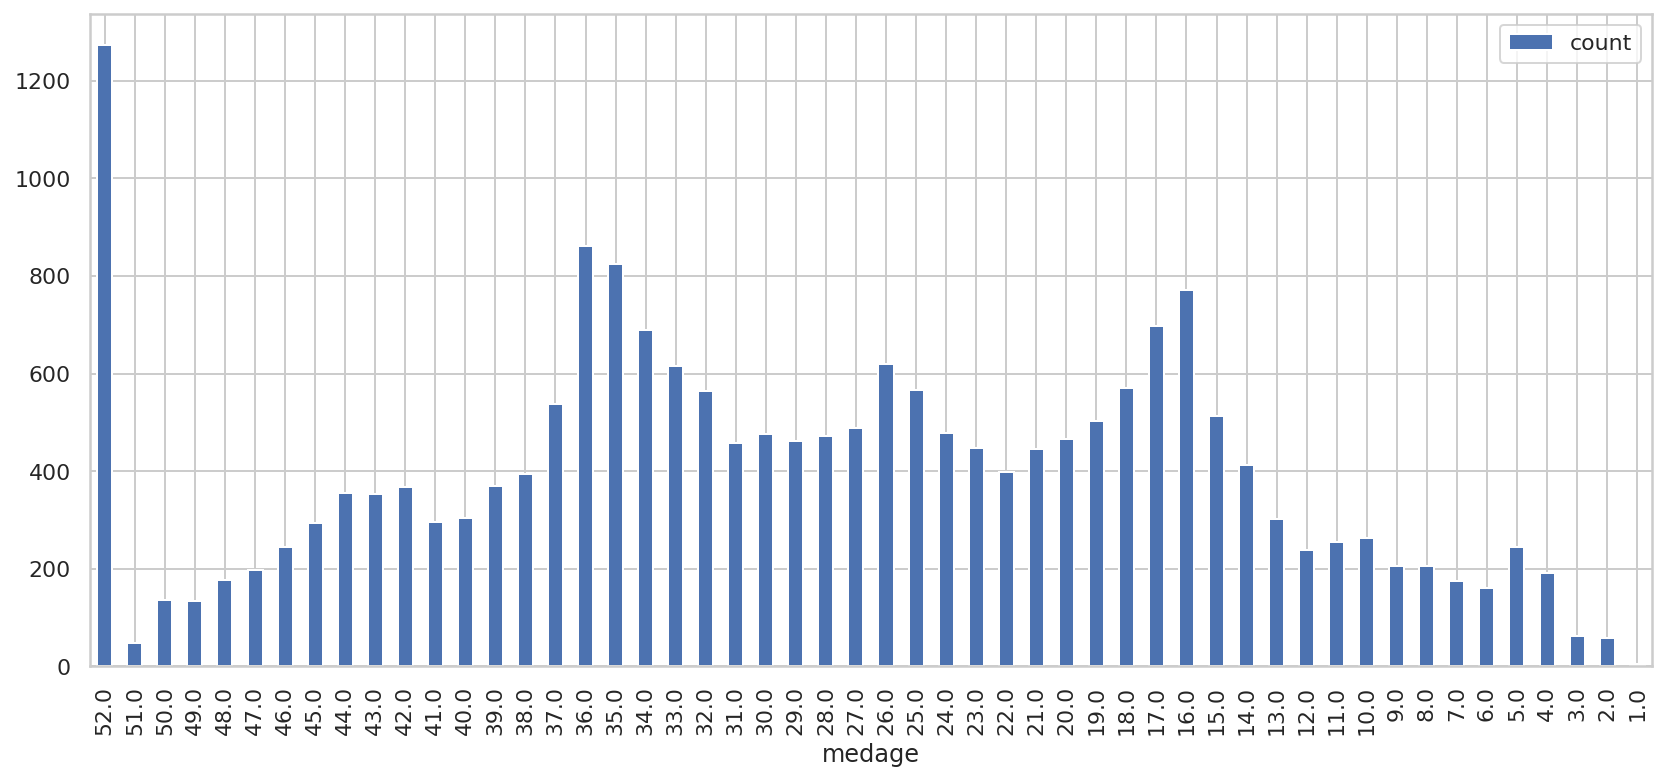

In [20]:
result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))

Most of the residents are either in their youth or middle age group. 

#### Summary Statistics
Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [21]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



Look at the minimum and maximum values of all the (numerical) attributes. We see that multiple attributes have a wide range of values: we will need to normalize the dataset.

### Data Preprocessing

* Standardize the data, as we have seen that the range of minimum and maximum values is quite big.

* There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.

* The dependent variable is large in value; To make it easier to work with it, we will slightly adjust the values.

#### Preprocessing The Target Values

First, let's start with the medianHouseValue, the dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526.

In [22]:
# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

In [23]:
# Show the first 2 lines of `df`
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



We can clearly see that the values have been adjusted correctly when we look at the result of the show() method.

### Feature Engineering

Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

*   Rooms per household which refers to the number of rooms in households per block group;

*   Population per household, which basically gives us an indication of how many people live in households per block group;
*   Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

As we are working with DataFrames, it is best to use the select() method to select the columns that we are going to work with, namely totalRooms, households, and population. Additionally, we need to indicate that we are working with columns by adding the col() function to our code. Otherwise, we won't be able to do element-wise operations like the division step ahead.




In [24]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [25]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn("rms_per_hh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("pop_per_hh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrms_per_rm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [26]:
# Inspect the result
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+----------+----------+------------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rms_per_hh|pop_per_hh|bdrms_per_rm|
+-------+-----+------+--------+--------+------+--------+------+-----+----------+----------+------------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|      6.98|      2.56|        0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|      6.24|      2.11|        0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|      8.29|       2.8|        0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|      5.82|      2.55|        0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|      6.28|      2.18|        0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+----------+----------+------------+
only showing top 5 rows



We can see that, for the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.5 people and the amount of bedrooms is quite low with 0.14.

We do not want to necessarily standardize our target values so we should ensure to to isolate those in our data set. Also let us leave out variables that we do not want to consider in our analysis, such as longitude, latitude, housingMedianAge and totalRooms.

In this case, we will use the select() method and passing the column names in the order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it will not be affected by the standardization.

In [27]:
# Re-order and select columns
housing_df = housing_df.select("medhv", 
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rms_per_hh", 
                              "pop_per_hh", 
                              "bdrms_per_rm")

#### Feature Extraction

Now that the data is re-ordered, we are ready to normalize the data. We will choose the features to be normalized.

In [28]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rms_per_hh", "pop_per_hh", "bdrms_per_rm"]

**Use a VectorAssembler to put features into a feature vector column**

In [29]:
# Put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

In [30]:
assembled_df = assembler.transform(housing_df)

In [31]:
assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+----------+----------+------------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rms_per_hh|pop_per_hh|bdrms_per_rm|features                                               |
+-----+--------+------+--------+------+----------+----------+------------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98      |2.56      |0.15        |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24      |2.11      |0.16        |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29      |2.8       |0.13        |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82      |2.55      |0.18        |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28      |2.18      |0.17        |[280.0,56

All the features have transformed into a Dense Vector.



#### Standardization

Next, we can finally scale the data using StandardScaler. The input columns are the features, and the output column with the rescaled values that will be included in the scaled_df will be named "features_scaled".

In [32]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [33]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [34]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

#### Building A Machine Learning Model With Spark ML

With all the preprocessing done, it's finally time to start building our Linear Regression model! First, split the data into training and test sets using the randomSplit() method:

In [35]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

We pass in a list with two numbers that represent the size that we want training and test sets to have including a seed.

Note that the argument elasticNetParam corresponds to  α  or the vertical intercept and that the regParam or the regularization paramater corresponds to  λ .

In [36]:
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rms_per_hh',
 'pop_per_hh',
 'bdrms_per_rm',
 'features',
 'features_scaled']

**Create an ElasticNet model**

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

In [37]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [38]:
# Fit the data to the model
linearModel = lr.fit(train_data)

### Evaluating the Model

We can now generate predictions for our test data by using the transform() method to predict the labels for our test_data. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame.

#### Inspect the Model Co-efficients

In [39]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [40]:
featureCols

['totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rms_per_hh',
 'pop_per_hh',
 'bdrms_per_rm']

In [41]:
# Intercept for the model
linearModel.intercept

1.001383351659608

In [42]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [43]:
coeff_df

,Feature,Co-efficients
0,Intercept,1.001383
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526157
5,rms_per_hh,0.000000
6,pop_per_hh,0.000000
7,bdrms_per_rm,0.000000


#### Generating Predictions

In [44]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [45]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")

In [46]:
predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|1.1498290146733698|0.14999|
| 1.303758290180578|  0.225|
|1.7529725743151858|  0.225|
|1.6094289295308721|  0.269|
|1.5956645319495766|  0.344|
|1.2917940087238424|  0.367|
|1.8668547795751218|  0.375|
|1.3694233397856368|  0.394|
| 1.530553343912004|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043996|  0.417|
|1.2299232046905868|  0.425|
| 1.484164070093314|  0.425|
|1.3510338217435216|   0.43|
|1.2619110212709583|  0.436|
|1.3350814464678742|   0.44|
|1.4832778453641753|   0.44|
|1.4337313361080326|  0.444|
|1.3691187093204964|  0.445|
|1.4752185586821598|  0.446|
+------------------+-------+
only showing top 20 rows



#### Inspect the Metrics

We will now inspect the metrics using the LinearRegressionModel.summary attribute, to pull up the rootMeanSquaredError and the r2 score.

In [47]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 0.881985204526886


In [48]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 0.678289531991799


In [49]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.4180854895364574


**Using the RegressionEvaluator from pyspark.ml package**

In [50]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.8677342923034236


In [51]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 0.673609774576463


In [52]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.42517112885139363


**Using the RegressionMetrics from pyspark.mllib package**



In [53]:
# mllib is old that is why the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [54]:
print("RMSE: {0}".format(metrics.rootMeanSquaredError))

RMSE: 0.8677342923034236


In [55]:
print("MAE: {0}".format(metrics.meanAbsoluteError))

MAE: 0.673609774576463


In [56]:
print("R2: {0}".format(metrics.r2))

R2: 0.42517112885139363


Improvements to the model are still needed! One should play around with the parameters that we passed to the model and the variables that we included in the original DataFrame.

In [57]:
spark.stop()